Code for trying to change particles status! :D

In [209]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [210]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [211]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking',
'home': '/home/vvalenzuela/MOAD/analysis-vicente/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/animations'}

In [212]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [213]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [214]:
#Definitions
start = datetime(2022, 8, 23) #Start date
length = 7 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 1 # 1000   # number of  locations
# Here the number of particles needs to be associated to the discharge rates from the Iona Outfall
n = 500 # number of particles per location
dmin = 40#minimum depth
dd = 20 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [215]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(datetime(2022, 8, 23),path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [216]:
#Set deploy coordinates following yaml   
clat = [49.195045]
clon = [-123.301956]
#
a, b = finder(clat[0], clon[0])
print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
#
duration = timedelta(days=length)
#
x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)
#
lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

The total depth at this location is 85.375 m


In [217]:
# Files for states runs
name_states = 'Draft_States_'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_states = os.path.join(path['out'], fn)
#
local = 0

In [218]:
varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)

#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)
#
#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)
#
#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)
#
# Fieldest for PON 
varlist=['PON', 'DIATO', 'FLAGE']
filenames, variables = filename_set(start, length, varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'deptht','time': 'time_counter'}
PON=Field.from_netcdf(filenames['PON'], variables['PON'], dimensions, allow_time_extrapolation=True, chunksize='auto')
DIATO=Field.from_netcdf(filenames['DIATO'], variables['DIATO'], dimensions, allow_time_extrapolation=True, chunksize='auto')
FLAGE=Field.from_netcdf(filenames['FLAGE'], variables['FLAGE'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#
field_set.add_field(PON)
field_set.add_field(DIATO)
field_set.add_field(FLAGE)

In [219]:
# Define PARTICLE TYPE and variables within itself
class MPParticle(JITParticle):    
    n = Variable('n', initial = n)
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0)
    initialized = Variable('initialized', initial = 0)
    status = Variable('status', initial =  1) # different status for different processes

In [220]:
pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

Tries before converting to Kernels!

In [221]:
# This is working!, status is being changes with random iteration between the total amount of deployed particles
data = ParcelsRandom.randint(0, n-1)
#
status = 0
# PBDEs as Sewage Particles
if data < n/3:
    status = 1
    print('Status is 1!! This is a Sewage Particle')
#
# Dissolved PBDEs
elif data >= n/3:
    status = 2
    print('Status is 2!! This is a Colloid')
#
# #
# #    
abs = 0.5
des = 0.8
dt = 1
value = random.random()
# Desorption from sewage particle to marine particle
if status == 1 and value < (des * dt):
    status = 2
    print("PBDE was attached to a SEWAGE PARTICLE and Desorption occured, now status is " ,status,"!! This means that the PBDEs is now floating around as a Colloid")
else:
    print('Status remains as ', status, ', the value condition is not satisfied!')    
#
if status == 2 and value < (abs * dt):
    status = 3
    print("Absorption occured, now status is ", status,"!! This means that the PBDEs that was floating is now attached to a marine particle")
else:
    print('Status remains as ', status, ', the value condition is not satisfied!')    

Status is 1!! This is a Sewage Particle
Status remains as  1 , the value condition is not satisfied!
Status remains as  1 , the value condition is not satisfied!


Kernels!

In [222]:
# Just for the beginning, not at every time!!
def states(particle, fieldset, time):
    if particle.initialized == 0:
        n = particle.n 
        # n is the total amount of particles released at the starting location
        data = ParcelsRandom.randint(0, n-1)
       # print('States Kernel is Running')

        #
        # PBDEs as Sewage Particles
        if data < 2*(n/3):
            particle.status = 1
        #
        # PBDEs a Colloids
        else:
            particle.status = 2
        #
        particle.initialized = 1    
     

In [223]:
def process(particle, fieldset, time):
    # HERE!! Add abso and deso values using model parameters, such as PON/POC and other features
    abso = 0.2
    deso = 0.4
    dt = 1
    #print('Process Kernel is Running')

    # Desorption from sewage particle to marine particle
    if particle.initialized == 1:
        value = ParcelsRandom.random()
        if particle.status == 1 and value < (deso * dt):
            particle.status = 2
            #print("PBDE was attached to a SEWAGE PARTICLE and Desorption occured, now status is 3!! This means that the PBDEs is now floating around as a Colloid")
            #
        elif particle.status == 2 and value < (abso * dt):
            particle.status = 3
            #print("Absorption occured, now status is 3!! This means that the PBDEs that was floating is now attached to a marine particle")           
        #    
        elif particle.status == 3 and value < (deso *dt):  
            particle.status = 2
            #print("Desorption from a Marine Particle!! This means that the PBDEs are floating around again")           
      

In [224]:
def PBDEs_forms(particle, fieldset, time):
    #print('PBDEs_forms Kernel is Running')

    # Sinking velocity for PBDEs in sewage particles
    if particle.status == 1:
        sinkvel = 0.0007
        particle.depth += sinkvel * particle.dt
    # Sinking velocity when colloids (just float around)        
    elif particle.status == 2:
        sinkvel = 0.0
        particle.depth += sinkvel * particle.dt
    # Sinking velocity for PBDEs in marine particles
    elif particle.status == 3:
        sinkvel = 0.0002
        particle.depth += sinkvel * particle.dt 


In [225]:
def Advection(particle, fieldset, time): 
    #print('Advection Kernel is Running')
    poc = (fieldset.particulate_organic_nitrogen[time, particle.depth, particle.lat, particle.lon]*1e8)*(16/106) # POC from PON using Redfield Ratio
    dia = fieldset.diatoms[time, particle.depth, particle.lat, particle.lon]*1e8
    flage = fieldset.flagellates[time, particle.depth, particle.lat, particle.lon]*1e8
    #
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/(td+ssh)
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

In [226]:
def turb_mix(particle,fieldset,time):
    #print('Turb_mix Kernel is Running')
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact

In [227]:
def Displacement(particle,fieldset,time):
    #print('Displacement Kernel is Running')
    '''Apply movement calculated by other kernels'''
    if particle.status == 1 or particle.status == 2 or particle.status == 3:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
            particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        else:
            particle_ddepth += dzs #apply mixing 

In [228]:
def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 5

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

In [229]:
#pset_states.execute([states, process, PBDEs_forms, Advection, turb_mix, Displacement, CheckOutOfBounds, export, KeepInOcean],
#            runtime=duration, 
#            dt=dt,
#            output_file=pset_states.ParticleFile(name=outfile_states, outputdt=timedelta(hours=odt)))            

In [230]:
pset_states.execute([states, process, PBDEs_forms, Advection, turb_mix, Displacement, CheckOutOfBounds, export, KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset_states.ParticleFile(name=outfile_states, outputdt=timedelta(hours=odt))) 

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking/Draft_States_20220823_1n_20220830_1n.zarr.
100%|██████████| 604800.0/604800.0 [23:19<00:00, 432.15it/s]


In [231]:
ds1 = xr.open_zarr(outfile_states)
depth1 = ds1.z*ds1.fact

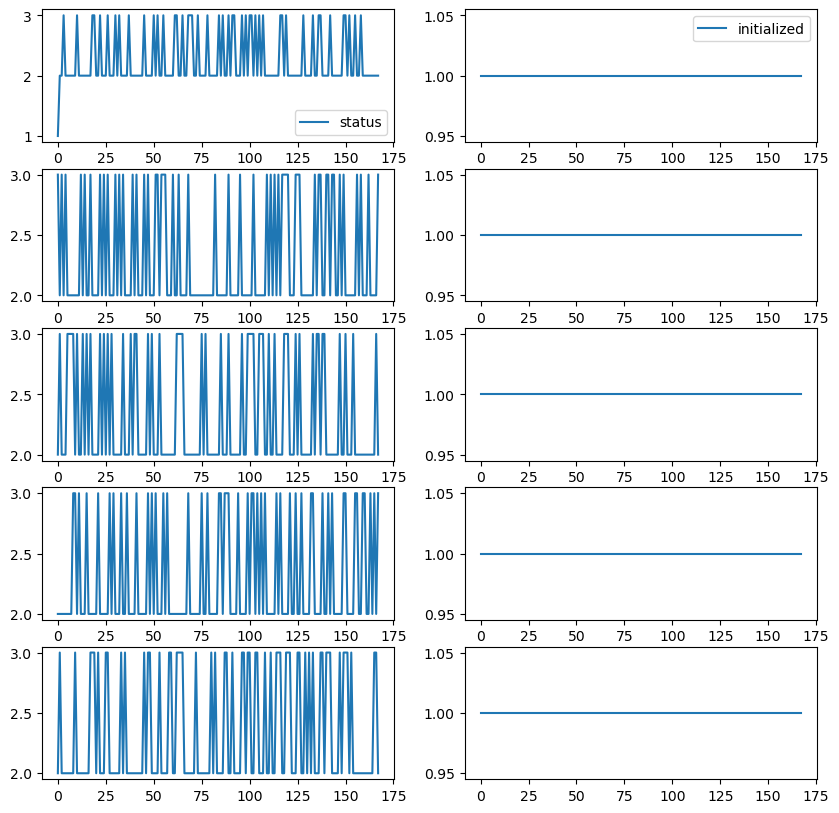

In [232]:
# check the particles status. See if it's working
fig, ax = plt.subplots(5,2,figsize=(10,10))

ax[0,0].plot(ds1.status[0,:], label='status')
ax[1,0].plot(ds1.status[1,:])
ax[2,0].plot(ds1.status[2,:])
ax[3,0].plot(ds1.status[3,:])
ax[4,0].plot(ds1.status[4,:])
#
ax[0,1].plot(ds1.initialized[0,:], label='initialized')
ax[1,1].plot(ds1.initialized[1,:])
ax[2,1].plot(ds1.initialized[2,:])
ax[3,1].plot(ds1.initialized[3,:])
ax[4,1].plot(ds1.initialized[4,:])
#
ax[0,0].legend()
ax[0,1].legend()


-States kernel is working ok; it's keeping the initial state for each particle through time.


-Process Kernel it seems to be overwriting the States Kernel, letting particles to change just between status 2 and 3


-PBDEs_forms Kernel is not affecting the other Kernels, since it's just changing a direct property of the particles, not changing their status


Text(0.5, 0.98, 'Particles from Iona Outfall Depths August 2022')

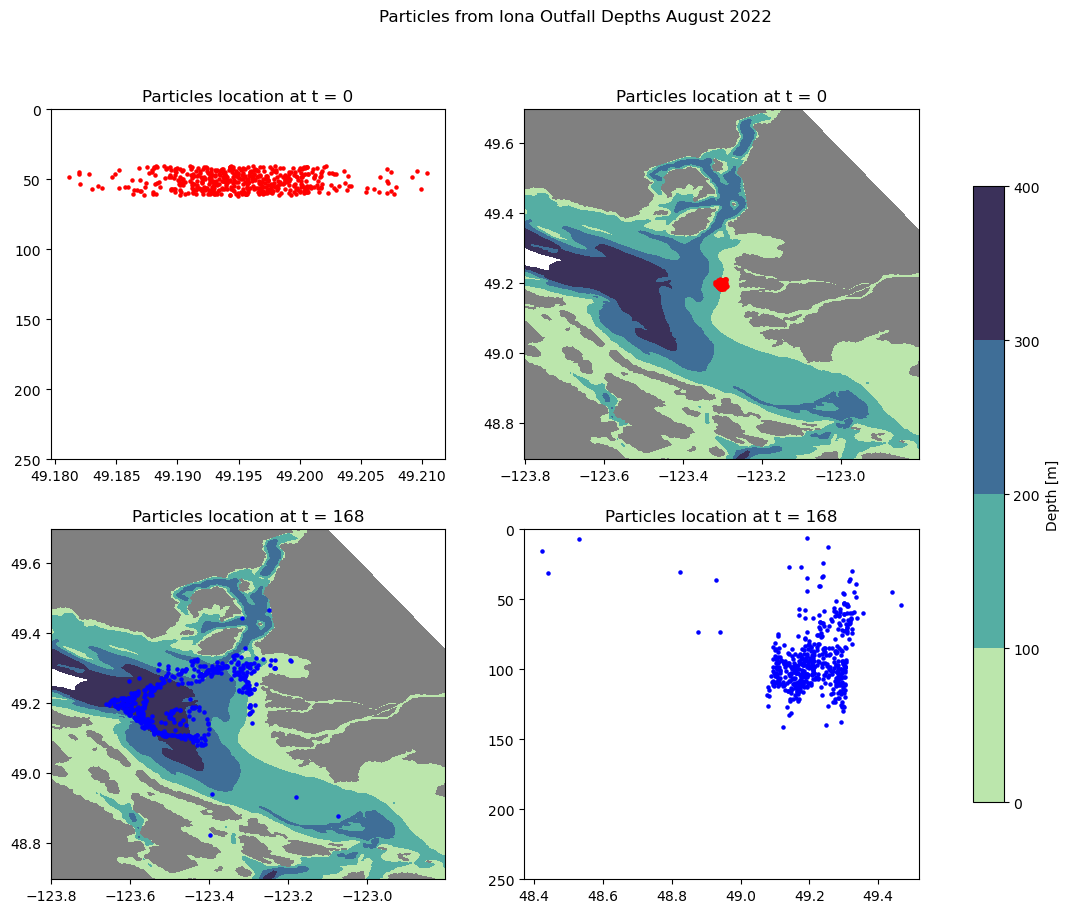

In [233]:
fig,axs=plt.subplots(2,2,figsize=(14,10))

axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c='r',s=5)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = {length*24}')

axs[1,1].scatter(ds1.lat[:,-1],depth1[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Particles from Iona Outfall Depths August 2022')

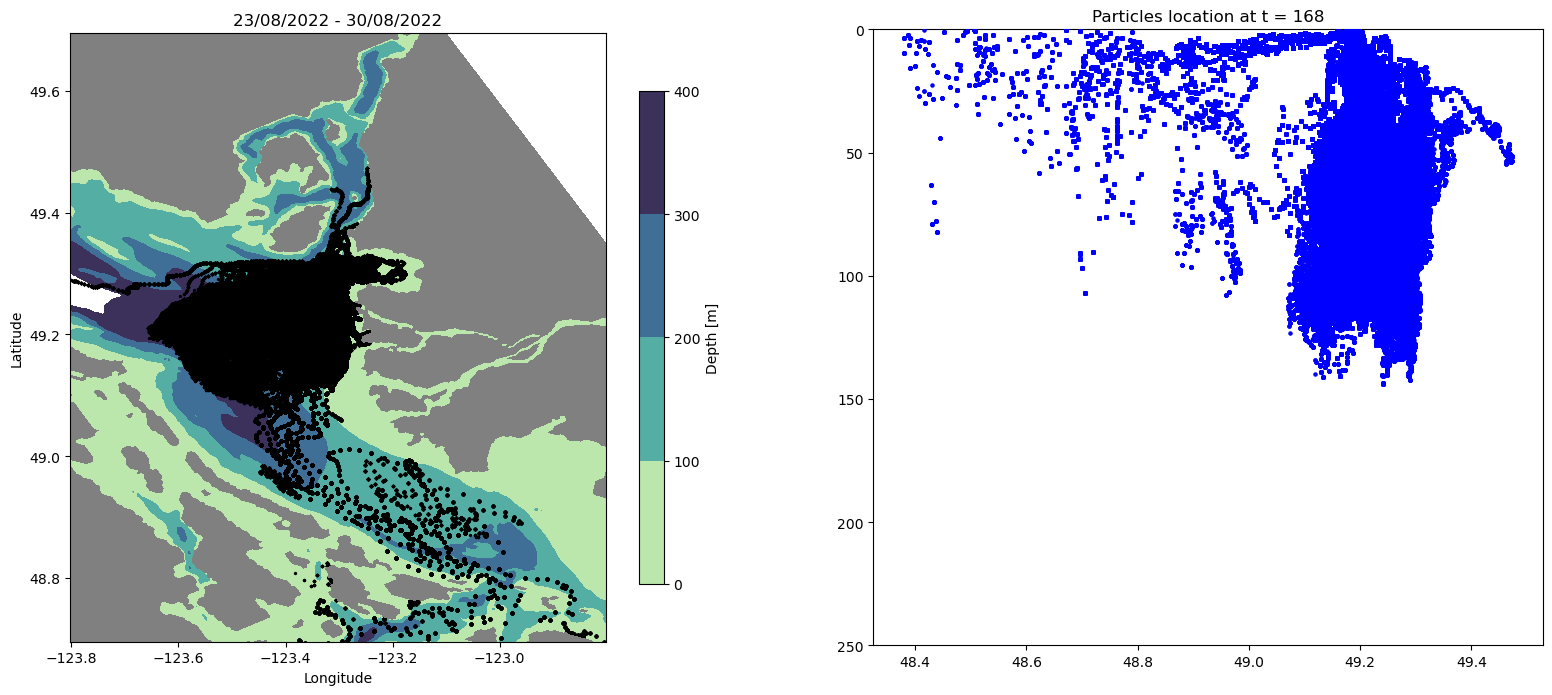

In [234]:
fig, ax = plt.subplots(1,2,figsize=(19, 8))
im = ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon[:, 0], ds1.lat[:, 0],s=2, c='k')
#ax.legend()
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
ax[0].set_aspect(5/4.4)
ax[1].set_ylim([250,0])
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('23/08/2022 - 30/08/2022')
nmin, nmax = 0, -1
#
cbar = fig.colorbar(im, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles_SM', artist='Vicente',
                comment='Particles movement (August 23-30, 2022)')
writer = FFMpegWriter(fps=10, metadata=metadata)

with writer.saving(fig, "Particle_States.mp4", 100):
    for tm in range(len(ds1.obs)):
        s = ax[0].scatter(ds1.lon[:, nmin:tm], ds1.lat[:, nmin:tm],s=2, c='k')
        a = ax[1].scatter(ds1.lat[:,nmin:tm],depth1[:,nmin:tm],zorder=3,c='b',s=5)
        ax[1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[tm]+1))
        writer.grab_frame()